# Perform Inferencing

Once we have a working model, it is time for the (hopefully) fun part. It is time to take the model for a test drive. We can load the model and test it against some data available for evaluating results not only on a single image, but on a video feed as well.

In [1]:
import os
from pathlib import Path
import sys
import zipfile

from arcgis.features import GeoAccessor
from arcgis.gis import GIS
from arcgis.learn import SingleShotDetector
import pandas as pd

In [37]:
# paths to common data locations - NOTE: to convert any path to a raw string, simply use str(path_instance)
dir_prj = Path.cwd().parent

dir_data = dir_prj/'data'

dir_raw = dir_data/'raw'
dir_int = dir_data/'interim'
dir_out = dir_data/'processed'

dir_models = dir_prj/'models'
        
# load the "autoreload" extension so that code can change, & always reload modules so that as you change code in src, it gets loaded
%load_ext autoreload
%autoreload 2

# create a GIS object instance as anonymous access to ArcGIS Online
gis = GIS()

gis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


GIS @ https://www.arcgis.com version:8.4

## Load the Model

In [30]:
mdl_pth = dir_models / 'pavement-cracks-model-resnet101' 

mdl_pth

WindowsPath('D:/projects/road-surface-detection/models/pavement-cracks-model-resnet101')

In [35]:
ssd = SingleShotDetector().load(mdl_pth)

TypeError: __init__() missing 1 required positional argument: 'data'

In [34]:
ssd = SingleShotDetector.from_model(mdl_pth)

ssd

<SingleShotDetector>

## Model inference

We will do model inference using the two methods: `predict` and `predict_video`. Let's get the data required to predict on image and video.

In [5]:
inf_itm = gis.content.get('92a75cec191e4dbbb53067761287b977')

inf_itm

<Item title:"pavement_cracks_data_inference" type:Image Collection owner:api_data_owner>

In [6]:
inf_zip_pth = dir_raw / inf_itm.name

if not inf_zip_pth.exists():
    inf_itm.download(save_path=dir_raw, file_name=inf_itm.name)

inf_zip_pth

WindowsPath('D:/projects/road-surface-detection/data/raw/pavement_cracks_data_inference.zip')

In [7]:
with zipfile.ZipFile(inf_zip_pth, 'r') as zip_ref:
    zip_ref.extractall(inf_zip_pth.parent)
    
dir_inf = inf_zip_pth.parent / inf_zip_pth.stem

dir_inf

WindowsPath('D:/projects/road-surface-detection/data/raw/pavement_cracks_data_inference')

In [8]:
img_file = dir_inf / 'test_img.jpg'
video_file = dir_inf / 'test_video.mp4'
metadata_file = dir_inf / 'metadata.csv'

img_file, video_file, metadata_file

(WindowsPath('D:/projects/road-surface-detection/data/raw/pavement_cracks_data_inference/test_img.jpg'),
 WindowsPath('D:/projects/road-surface-detection/data/raw/pavement_cracks_data_inference/test_video.mp4'),
 WindowsPath('D:/projects/road-surface-detection/data/raw/pavement_cracks_data_inference/metadata.csv'))

### Detecting pavement cracks on an image

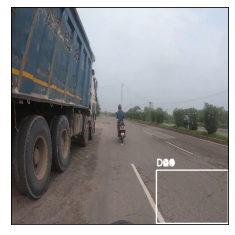

In [9]:
bbox_data = ssd.predict(str(img_file), threshold=0.1, visualize=True)

### Detecting pavement cracks from video feed

In [10]:
ssd.predict_video(input_video_path=str(video_file), metadata_file=metadata_file, visualize=True, resize=True)

<video width="100%" height="450" loop="loop" controls src="../../static/video/road_crack_prediction.mp4" />

## Publish results to your GIS

The `predict_video` function also updates the metadata file provided in csv format with the detections at each frame. We will now read this csv using pandas and publish it as a layer on our GIS.

In [11]:
inf_df = pd.read_csv(metadata_file)

inf_df

,UNIX Time Stamp,Sensor Latitude,Sensor Longitude,Sensor True Altitude,Frame Center Latitude,Frame Center Longitude,Frame Center Elevation,vmtilocaldataset
0,1.564889e+15,28.412995,77.162906,294.736633,28.412995,77.162906,294.736633,\n
1,1.564889e+15,28.412995,77.162904,294.729656,28.412995,77.162904,294.729656,\n
2,1.564889e+15,28.412996,77.162902,294.722680,28.412996,77.162902,294.722680,\n
3,1.564889e+15,28.412997,77.162901,294.715703,28.412997,77.162901,294.715703,\n
4,1.564889e+15,28.412997,77.162899,294.708546,28.412997,77.162899,294.708546,\n
...,...,...,...,...,...,...,...,...
1794,1.564889e+15,28.414831,77.159583,278.085715,28.414831,77.159583,278.085715,NaN
1795,1.564889e+15,28.414831,77.159581,278.076278,28.414831,77.159581,278.076278,NaN
1796,1.564889e+15,28.414830,77.159578,278.066841,28.414830,77.159578,278.066841,NaN
1797,1.564889e+15,28.414830,77.159576,278.057561,28.414830,77.159576,278.057561,NaN


The code below removes rows from the DataFrame with no detections and also creates a new columns which contains count of the number of detections at each frame.

In [12]:
# Handle NAN and '\n' values
inf_df.vmtilocaldataset = inf_df.vmtilocaldataset.str.strip()
inf_df.loc[inf_df.vmtilocaldataset == '', 'vmtilocaldataset'] = ''
inf_df['count'] = ( inf_df['vmtilocaldataset'].str.split(';').str.len().fillna(1) - 1 )

inf_df.head()

,UNIX Time Stamp,Sensor Latitude,Sensor Longitude,Sensor True Altitude,Frame Center Latitude,Frame Center Longitude,Frame Center Elevation,vmtilocaldataset,count
0,1.564889e+15,28.412995,77.162906,294.736633,28.412995,77.162906,294.736633,,0.0
1,1.564889e+15,28.412995,77.162904,294.729656,28.412995,77.162904,294.729656,,0.0
2,1.564889e+15,28.412996,77.162902,294.722680,28.412996,77.162902,294.722680,,0.0
3,1.564889e+15,28.412997,77.162901,294.715703,28.412997,77.162901,294.715703,,0.0
4,1.564889e+15,28.412997,77.162899,294.708546,28.412997,77.162899,294.708546,,0.0


In [13]:
fps = 60

inf_df['group'] = pd.Series( (inf_df.index.values / fps) - .49 ).round().abs()

inf_df.tail()

,UNIX Time Stamp,Sensor Latitude,Sensor Longitude,Sensor True Altitude,Frame Center Latitude,Frame Center Longitude,Frame Center Elevation,vmtilocaldataset,count,group
1794,1.564889e+15,28.414831,77.159583,278.085715,28.414831,77.159583,278.085715,NaN,0.0,29.0
1795,1.564889e+15,28.414831,77.159581,278.076278,28.414831,77.159581,278.076278,NaN,0.0,29.0
1796,1.564889e+15,28.414830,77.159578,278.066841,28.414830,77.159578,278.066841,NaN,0.0,29.0
1797,1.564889e+15,28.414830,77.159576,278.057561,28.414830,77.159576,278.057561,NaN,0.0,29.0
1798,1.564889e+15,28.414829,77.159574,278.047585,28.414829,77.159574,278.047585,NaN,0.0,29.0


In [14]:
# Get index of row with max detections in each group
max_detection_idxes = inf_df[['group', 'count']].groupby('group').idxmax()['count'].values

max_detection_idxes

array([   0,   60,  130,  180,  246,  302,  405,  424,  482,  540,  600,  678,  720,  820,  885,  900,  960, 1020,
       1080, 1140, 1200, 1260, 1320, 1380, 1440, 1500, 1560, 1620, 1680, 1740], dtype=int64)

In [15]:
# Extract rows for the indexes
df_flt = inf_df.iloc[max_detection_idxes]

In [16]:
sdf = pd.DataFrame.spatial.from_xy(df_flt.loc[inf_df['count']!=0].copy(), 'Sensor Longitude', 'Sensor Latitude')

sdf.head()

,UNIX Time Stamp,Sensor Latitude,Sensor Longitude,Sensor True Altitude,Frame Center Latitude,Frame Center Longitude,Frame Center Elevation,vmtilocaldataset,count,group,SHAPE
130,1.564889e+15,28.413087,77.162667,293.931796,28.413087,77.162667,293.931796,1 54.02768850326538 1504652 2067840 1787205;,1.0,2.0,"{""spatialReference"": {""wkid"": 4326}, ""x"": 77.1..."
180,1.564889e+15,28.413130,77.162573,293.577866,28.413130,77.162573,293.577866,1 56.72200322151184 1527613 2069760 1798686;,1.0,3.0,"{""spatialReference"": {""wkid"": 4326}, ""x"": 77.1..."
246,1.564889e+15,28.413196,77.162448,293.090740,28.413196,77.162448,293.090740,1 50.19106864929199 1646772 2065906 1858259;,1.0,4.0,"{""spatialReference"": {""wkid"": 4326}, ""x"": 77.1..."
302,1.564889e+15,28.413259,77.162343,292.778962,28.413259,77.162343,292.778962,1 50.52756071090698 1470720 2070324 1772442;,1.0,5.0,"{""spatialReference"": {""wkid"": 4326}, ""x"": 77.1..."
405,1.564889e+15,28.413394,77.162152,292.410324,28.413394,77.162152,292.410324,1 57.28030204772949 1169310 2072378 1620843;,1.0,6.0,"{""spatialReference"": {""wkid"": 4326}, ""x"": 77.1..."


In [25]:
webmap = sdf.spatial.plot(
    renderer_type='c',  # for class breaks renderer
    method='esriClassifyNaturalBreaks',  # classification algorithm
    class_count=20,  # choose the number of classes
    col='count',  # numeric column to classify
    cmap='gnuplot2_r',  # color map to pick colors from for each class
    alpha=1  # specify opacity
)
webmap.basemap = "satellite"
webmap

MapView(layout=Layout(height='400px', width='100%'))